# Stock Data Exploration

Analysis of stock price data for LSTM prediction models.
Target companies: Apple (AAPL), Google (GOOGL), Meta (META), Tesla (TSLA).

## Contents
1. Data Loading
2. Basic Statistics  
3. Price Trends
4. Technical Indicators
5. Correlation Analysis
6. Volatility Analysis
7. LSTM Data Preparation

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import yfinance as yf
import ta
from datetime import datetime, timedelta
import warnings

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading

Load stock data for the past 2 years.

In [20]:
# Define stock symbols
symbols = ['AAPL', 'GOOGL', 'META', 'TSLA']
company_names = {
    'AAPL': 'Apple Inc.',
    'GOOGL': 'Alphabet Inc. (Google)',
    'META': 'Meta Platforms Inc.',
    'TSLA': 'Tesla Inc.'
}

# Download data for the past 2 years
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * 10)  # Adjusted to 10 years for a more comprehensive dataset

print(f"Downloading data from {start_date.date()} to {end_date.date()}")
print("Downloading data for symbols:", ', '.join(symbols))

stock_data = {}

for symbol in symbols:
    try:
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=start_date, end=end_date)
        
        data.columns = [col.lower().replace(' ', '_') for col in data.columns]
        data['symbol'] = symbol
        data.reset_index(inplace=True)
        data.rename(columns={'date': 'timestamp'}, inplace=True)
        
        stock_data[symbol] = data
        print(f"{symbol}: {len(data)} records downloaded")
        
    except Exception as e:
        print(f"Error downloading {symbol}: {str(e)}")

print(f"Data download completed for {len(stock_data)} symbols")

AAPL: 2512 records downloaded
GOOGL: 2512 records downloaded
AAPL: 2512 records downloaded
GOOGL: 2512 records downloaded
META: 2512 records downloaded
TSLA: 2512 records downloaded
Data download completed for 4 symbols
META: 2512 records downloaded
TSLA: 2512 records downloaded
Data download completed for 4 symbols


## 2. Basic Statistics

Basic information about the datasets.

In [22]:
# Display basic information for each stock
for symbol in symbols:
    if symbol in stock_data:
        data = stock_data[symbol].copy()
        print(f"\n{'='*50}")
        print(f"STOCK: {symbol} - {company_names[symbol]}")
        print(f"{'='*50}")
        
        print(f"\nDataset Info:")
        # Check if timestamp column exists, otherwise use index
        if 'timestamp' in data.columns:
            date_col = 'timestamp'
        elif 'Date' in data.columns:
            date_col = 'Date'
        else:
            date_col = data.index
            
        if isinstance(date_col, str):
            print(f"Date range: {data[date_col].min().date()} to {data[date_col].max().date()}")
        else:
            print(f"Date range: {date_col.min().date()} to {date_col.max().date()}")
            
        print(f"Total records: {len(data)}")
        print(f"Missing values: {data.isnull().sum().sum()}")
        
        print(f"\nPrice Statistics:")
        print(data[['open', 'high', 'low', 'close', 'volume']].describe())
        
        # Calculate some basic metrics
        data['daily_return'] = data['close'].pct_change()
        data['volatility'] = data['daily_return'].rolling(window=30).std()
        
        print(f"\nAdditional Metrics:")
        print(f"Average daily return: {data['daily_return'].mean()*100:.3f}%")
        print(f"Daily return std: {data['daily_return'].std()*100:.3f}%")
        print(f"Max single day gain: {data['daily_return'].max()*100:.2f}%")
        print(f"Max single day loss: {data['daily_return'].min()*100:.2f}%")
        print(f"Sharpe ratio (approx): {(data['daily_return'].mean() / data['daily_return'].std() * np.sqrt(252)):.3f}")


STOCK: AAPL - Apple Inc.

Dataset Info:
Date range: 2015-08-03 to 2025-07-29
Total records: 2512
Missing values: 0

Price Statistics:
              open         high          low        close        volume
count  2512.000000  2512.000000  2512.000000  2512.000000  2.512000e+03
mean    104.679020   105.829321   103.619365   104.780221  1.085630e+08
std      69.119375    69.869054    68.436553    69.196120  6.380050e+07
min      20.569754    20.951437    20.448619    20.647459  1.057929e+07
25%      39.674075    40.075566    39.206499    39.667556  6.590922e+07
50%      95.386707    96.476647    93.849636    94.775532  9.354610e+07
75%     165.546833   167.447940   163.863146   165.735012  1.316198e+08
max     257.568678   259.474086   257.010028   258.396667  6.488252e+08

Additional Metrics:
Average daily return: 0.100%
Daily return std: 1.850%
Max single day gain: 15.33%
Max single day loss: -12.86%
Sharpe ratio (approx): 0.859

STOCK: GOOGL - Alphabet Inc. (Google)

Dataset Info:
Da

## 3. Price Trend Visualization <a id="price-trends"></a>

Now let's visualize the price trends for all stocks to understand their behavior over time.

In [24]:
# Create interactive price comparison chart
fig = go.Figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, symbol in enumerate(symbols):
    if symbol in stock_data:
        data = stock_data[symbol]
        # Get date column
        if 'timestamp' in data.columns:
            date_col = data['timestamp']
        elif 'Date' in data.columns:
            date_col = data['Date']
        else:
            date_col = data.index
            
        fig.add_trace(go.Scatter(
            x=date_col,
            y=data['close'],
            mode='lines',
            name=f'{symbol} - {company_names[symbol]}',
            line=dict(color=colors[i], width=2),
            hovertemplate=f'<b>{symbol}</b><br>' +
                         'Date: %{x}<br>' +
                         'Price: $%{y:.2f}<extra></extra>'
        ))

fig.update_layout(
    title='Stock Price Comparison - Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price ($)',
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [25]:
# Normalized price comparison (starting from 100)
fig = go.Figure()

for i, symbol in enumerate(symbols):
    if symbol in stock_data:
        data = stock_data[symbol]
        normalized_price = (data['close'] / data['close'].iloc[0]) * 100
        
        # Get date column
        if 'timestamp' in data.columns:
            date_col = data['timestamp']
        elif 'Date' in data.columns:
            date_col = data['Date']
        else:
            date_col = data.index
        
        fig.add_trace(go.Scatter(
            x=date_col,
            y=normalized_price,
            mode='lines',
            name=f'{symbol}',
            line=dict(color=colors[i], width=2),
            hovertemplate=f'<b>{symbol}</b><br>' +
                         'Date: %{x}<br>' +
                         'Normalized Price: %{y:.1f}<extra></extra>'
        ))

fig.update_layout(
    title='Normalized Stock Price Comparison (Base = 100)',
    xaxis_title='Date',
    yaxis_title='Normalized Price',
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [26]:
# Volume analysis
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[f'{symbol} - Volume' for symbol in symbols],
    vertical_spacing=0.08
)

positions = [(1,1), (1,2), (2,1), (2,2)]

for i, symbol in enumerate(symbols):
    if symbol in stock_data:
        data = stock_data[symbol]
        row, col = positions[i]
        
        # Get date column
        if 'timestamp' in data.columns:
            date_col = data['timestamp']
        elif 'Date' in data.columns:
            date_col = data['Date']
        else:
            date_col = data.index
        
        fig.add_trace(
            go.Scatter(
                x=date_col,
                y=data['volume'],
                mode='lines',
                name=symbol,
                line=dict(color=colors[i]),
                showlegend=False
            ),
            row=row, col=col
        )

fig.update_layout(
    title='Trading Volume Analysis',
    height=700,
    template='plotly_white'
)

fig.show()

## 4. Technical Indicators Analysis <a id="technical-indicators"></a>

Let's add technical indicators to our analysis. These will be crucial features for our LSTM model.

In [28]:
def add_technical_indicators(data):
    """Add common technical indicators to stock data."""
    df = data.copy()
    
    # Moving averages
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['ema_12'] = df['close'].ewm(span=12).mean()
    df['ema_26'] = df['close'].ewm(span=26).mean()
    
    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['close']).rsi()
    
    # MACD
    macd = ta.trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_histogram'] = macd.macd_diff()
    
    # Bollinger Bands
    bb = ta.volatility.BollingerBands(df['close'])
    df['bb_upper'] = bb.bollinger_hband()
    df['bb_middle'] = bb.bollinger_mavg()
    df['bb_lower'] = bb.bollinger_lband()
    df['bb_width'] = bb.bollinger_wband()
    
    # Average True Range (volatility)
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close']).average_true_range()
    
    return df

# Add technical indicators to all stocks
for symbol in symbols:
    if symbol in stock_data:
        stock_data[symbol] = add_technical_indicators(stock_data[symbol])
        print(f"Technical indicators added for {symbol}")

print("Technical indicators calculated for all stocks")

Technical indicators added for AAPL
Technical indicators added for GOOGL
Technical indicators added for META
Technical indicators added for TSLA
Technical indicators calculated for all stocks


In [29]:
# Visualize technical indicators for AAPL as an example
symbol = 'AAPL'
data = stock_data[symbol]

# Get date column
if 'timestamp' in data.columns:
    date_col = data['timestamp']
elif 'Date' in data.columns:
    date_col = data['Date']
else:
    date_col = data.index

# Create subplots for comprehensive technical analysis
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=(
        f'{symbol} Price with Moving Averages and Bollinger Bands',
        'MACD',
        'RSI',
        'Volume and ATR'
    ),
    vertical_spacing=0.05,
    row_heights=[0.4, 0.2, 0.2, 0.2],
    specs=[[{"secondary_y": False}],
           [{"secondary_y": False}],
           [{"secondary_y": False}],
           [{"secondary_y": True}]]
)

# Price and Bollinger Bands
fig.add_trace(
    go.Scatter(x=date_col, y=data['close'], name='Close Price', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=date_col, y=data['sma_20'], name='SMA 20', line=dict(color='orange', dash='dash')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=date_col, y=data['sma_50'], name='SMA 50', line=dict(color='red', dash='dash')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=date_col, y=data['bb_upper'], name='BB Upper', line=dict(color='gray', dash='dot')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=date_col, y=data['bb_lower'], name='BB Lower', line=dict(color='gray', dash='dot')),
    row=1, col=1
)

# MACD
fig.add_trace(
    go.Scatter(x=date_col, y=data['macd'], name='MACD', line=dict(color='blue')),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=date_col, y=data['macd_signal'], name='MACD Signal', line=dict(color='red')),
    row=2, col=1
)
fig.add_trace(
    go.Bar(x=date_col, y=data['macd_histogram'], name='MACD Histogram', marker_color='green', opacity=0.6),
    row=2, col=1
)

# RSI
fig.add_trace(
    go.Scatter(x=date_col, y=data['rsi'], name='RSI', line=dict(color='purple')),
    row=3, col=1
)
# Add RSI overbought/oversold lines
fig.add_hline(y=70, line_dash="dash", line_color="red", row=3, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=3, col=1)

# Volume and ATR
fig.add_trace(
    go.Bar(x=date_col, y=data['volume'], name='Volume', marker_color='lightblue', opacity=0.7),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=date_col, y=data['atr'], name='ATR', line=dict(color='orange')),
    row=4, col=1, secondary_y=True
)

# Update layout
fig.update_layout(
    title=f'{symbol} - Comprehensive Technical Analysis',
    height=1000,
    showlegend=True,
    template='plotly_white'
)

# Update y-axes
fig.update_yaxes(title_text="Price ($)", row=1, col=1)
fig.update_yaxes(title_text="MACD", row=2, col=1)
fig.update_yaxes(title_text="RSI", row=3, col=1, range=[0, 100])
fig.update_yaxes(title_text="Volume", row=4, col=1)
fig.update_yaxes(title_text="ATR", row=4, col=1, secondary_y=True)

fig.show()

## 5. Correlation Analysis <a id="correlation"></a>

Let's analyze correlations between different stocks and their features.

In [30]:
# Create a combined dataset with closing prices for correlation analysis
price_data = pd.DataFrame()

for symbol in symbols:
    if symbol in stock_data:
        data = stock_data[symbol]
        # Get date column and set as index
        if 'timestamp' in data.columns:
            price_data[symbol] = data.set_index('timestamp')['close']
        elif 'Date' in data.columns:
            price_data[symbol] = data.set_index('Date')['close']
        else:
            price_data[symbol] = data['close']

# Calculate daily returns for correlation
returns_data = price_data.pct_change().dropna()

# Price correlation
price_corr = price_data.corr()
print("Stock Price Correlations:")
print(price_corr.round(3))

# Returns correlation
returns_corr = returns_data.corr()
print("\nDaily Returns Correlations:")
print(returns_corr.round(3))

Stock Price Correlations:
        AAPL  GOOGL   META   TSLA
AAPL   1.000  0.969  0.819  0.918
GOOGL  0.969  1.000  0.882  0.903
META   0.819  0.882  1.000  0.701
TSLA   0.918  0.903  0.701  1.000

Daily Returns Correlations:
        AAPL  GOOGL   META   TSLA
AAPL   1.000  0.615  0.534  0.440
GOOGL  0.615  1.000  0.638  0.392
META   0.534  0.638  1.000  0.342
TSLA   0.440  0.392  0.342  1.000


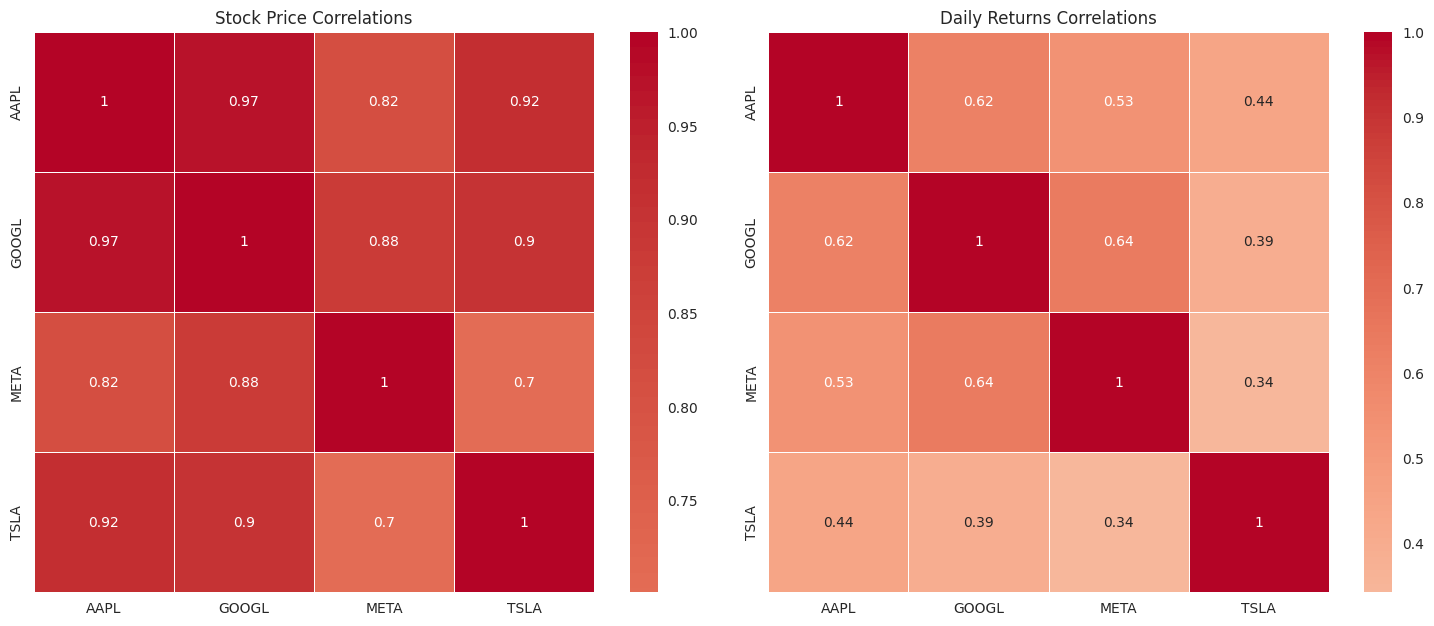

In [31]:
# Visualize correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Price correlation heatmap
sns.heatmap(price_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Stock Price Correlations')

# Returns correlation heatmap
sns.heatmap(returns_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, ax=axes[1])
axes[1].set_title('Daily Returns Correlations')

plt.tight_layout()
plt.show()

In [32]:
# Feature correlation analysis for AAPL
symbol = 'AAPL'
data = stock_data[symbol]

# Select numerical features for correlation analysis
feature_columns = ['close', 'volume', 'sma_20', 'sma_50', 'ema_12', 'ema_26', 
                   'rsi', 'macd', 'bb_width', 'atr']

feature_data = data[feature_columns].dropna()
feature_corr = feature_data.corr()

# Create interactive correlation heatmap
fig = go.Figure(data=go.Heatmap(
    z=feature_corr.values,
    x=feature_corr.columns,
    y=feature_corr.columns,
    colorscale='RdBu',
    zmid=0,
    text=feature_corr.round(3).values,
    texttemplate='%{text}',
    textfont={"size": 12},
    hovertemplate='<b>%{y} vs %{x}</b><br>Correlation: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title=f'{symbol} - Feature Correlation Matrix',
    width=800,
    height=600
)

fig.show()

## 6. Volatility Analysis <a id="volatility"></a>

Volatility is crucial for understanding risk and potential model performance.

In [33]:
# Calculate rolling volatility for all stocks
volatility_data = pd.DataFrame()

for symbol in symbols:
    if symbol in stock_data:
        data = stock_data[symbol]
        daily_returns = data['close'].pct_change()
        rolling_vol = daily_returns.rolling(window=30).std() * np.sqrt(252)  # Annualized volatility
        volatility_data[symbol] = rolling_vol
        
        # Set index based on available date column
        if 'timestamp' in data.columns:
            volatility_data.index = data['timestamp']
        elif 'Date' in data.columns:
            volatility_data.index = data['Date']
        else:
            volatility_data.index = data.index

# Plot volatility comparison
fig = go.Figure()

for i, symbol in enumerate(symbols):
    if symbol in volatility_data.columns:
        fig.add_trace(go.Scatter(
            x=volatility_data.index,
            y=volatility_data[symbol] * 100,  # Convert to percentage
            mode='lines',
            name=f'{symbol}',
            line=dict(color=colors[i]),
            hovertemplate=f'<b>{symbol}</b><br>' +
                         'Date: %{x}<br>' +
                         'Volatility: %{y:.1f}%<extra></extra>'
        ))

fig.update_layout(
    title='Rolling 30-Day Annualized Volatility Comparison',
    xaxis_title='Date',
    yaxis_title='Volatility (%)',
    height=500,
    template='plotly_white'
)

fig.show()

In [34]:
# Volatility statistics
print("Volatility Statistics (Annualized %):\n")
vol_stats = (volatility_data * 100).describe()
print(vol_stats.round(2))

# Risk-Return scatter plot
fig = go.Figure()

for symbol in symbols:
    if symbol in stock_data:
        data = stock_data[symbol]
        daily_returns = data['close'].pct_change().dropna()
        
        annual_return = (daily_returns.mean() * 252) * 100  # Annualized return %
        annual_volatility = (daily_returns.std() * np.sqrt(252)) * 100  # Annualized volatility %
        
        fig.add_trace(go.Scatter(
            x=[annual_volatility],
            y=[annual_return],
            mode='markers+text',
            name=symbol,
            text=[symbol],
            textposition="top center",
            marker=dict(size=15, color=colors[symbols.index(symbol)]),
            hovertemplate=f'<b>{symbol}</b><br>' +
                         'Annual Return: %{y:.1f}%<br>' +
                         'Annual Volatility: %{x:.1f}%<extra></extra>'
        ))

fig.update_layout(
    title='Risk vs Return Analysis',
    xaxis_title='Annual Volatility (%)',
    yaxis_title='Annual Return (%)',
    height=500,
    template='plotly_white',
    showlegend=False
)

fig.show()

Volatility Statistics (Annualized %):

          AAPL  GOOGL  META  TSLA
count  2482.00    0.0   0.0   0.0
mean     26.77    NaN   NaN   NaN
std      12.12    NaN   NaN   NaN
min       8.07    NaN   NaN   NaN
25%      19.08    NaN   NaN   NaN
50%      23.92    NaN   NaN   NaN
75%      30.31    NaN   NaN   NaN
max      95.60    NaN   NaN   NaN


## 7. LSTM Data Preparation <a id="lstm-prep"></a>

Now let's prepare the data specifically for LSTM training, including sequence creation and normalization.

In [35]:
from sklearn.preprocessing import MinMaxScaler

def prepare_lstm_data(data, sequence_length=60, target_column='close', feature_columns=None):
    """
    Prepare data for LSTM training.
    
    Args:
        data: Stock data DataFrame
        sequence_length: Length of input sequences
        target_column: Column to predict
        feature_columns: List of feature columns to use
    
    Returns:
        Dictionary with prepared data
    """
    if feature_columns is None:
        feature_columns = ['open', 'high', 'low', 'close', 'volume']
    
    # Select and clean data
    df = data[feature_columns + [target_column]].dropna().copy()
    
    # Normalize features
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    
    features_scaled = scaler_features.fit_transform(df[feature_columns])
    target_scaled = scaler_target.fit_transform(df[[target_column]])
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(target_scaled[i, 0])
    
    X, y = np.array(X), np.array(y)
    
    # Split data (80% train, 20% test)
    train_size = int(len(X) * 0.8)
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler_features': scaler_features,
        'scaler_target': scaler_target,
        'feature_columns': feature_columns,
        'sequence_length': sequence_length
    }

# Prepare data for each stock
lstm_data = {}
sequence_length = 60

# Enhanced feature set including technical indicators
enhanced_features = ['open', 'high', 'low', 'close', 'volume', 
                    'sma_20', 'rsi', 'macd', 'bb_width', 'atr']

for symbol in symbols:
    if symbol in stock_data:
        print(f"Preparing LSTM data for {symbol}...")
        
        # Basic features
        basic_data = prepare_lstm_data(
            stock_data[symbol], 
            sequence_length=sequence_length,
            feature_columns=['open', 'high', 'low', 'close', 'volume']
        )
        
        # Enhanced features
        enhanced_data = prepare_lstm_data(
            stock_data[symbol], 
            sequence_length=sequence_length,
            feature_columns=enhanced_features
        )
        
        lstm_data[symbol] = {
            'basic': basic_data,
            'enhanced': enhanced_data
        }
        
        print(f"  Basic features - Train: {basic_data['X_train'].shape}, Test: {basic_data['X_test'].shape}")
        print(f"  Enhanced features - Train: {enhanced_data['X_train'].shape}, Test: {enhanced_data['X_test'].shape}")

print("\nLSTM data preparation completed!")

Preparing LSTM data for AAPL...
  Basic features - Train: (1961, 60, 6), Test: (491, 60, 6)
  Enhanced features - Train: (1941, 60, 11), Test: (486, 60, 11)
Preparing LSTM data for GOOGL...
  Basic features - Train: (1961, 60, 6), Test: (491, 60, 6)
  Enhanced features - Train: (1941, 60, 11), Test: (486, 60, 11)
Preparing LSTM data for META...
  Basic features - Train: (1961, 60, 6), Test: (491, 60, 6)
  Enhanced features - Train: (1941, 60, 11), Test: (486, 60, 11)
Preparing LSTM data for TSLA...
  Basic features - Train: (1961, 60, 6), Test: (491, 60, 6)
  Enhanced features - Train: (1941, 60, 11), Test: (486, 60, 11)

LSTM data preparation completed!


In [36]:
# Visualize data shapes and statistics
print("LSTM Data Summary:")
print("=" * 50)

for symbol in symbols:
    if symbol in lstm_data:
        basic = lstm_data[symbol]['basic']
        enhanced = lstm_data[symbol]['enhanced']
        
        print(f"\n{symbol}:")
        print(f"  Sequence length: {sequence_length}")
        print(f"  Basic features ({len(basic['feature_columns'])}):\n    {basic['feature_columns']}")
        print(f"  Enhanced features ({len(enhanced['feature_columns'])}):\n    {enhanced['feature_columns']}")
        print(f"  Training samples: {len(basic['X_train'])}")
        print(f"  Test samples: {len(basic['X_test'])}")
        
        # Show target statistics
        print(f"  Target (scaled) - Train range: [{basic['y_train'].min():.3f}, {basic['y_train'].max():.3f}]")
        print(f"  Target (scaled) - Test range: [{basic['y_test'].min():.3f}, {basic['y_test'].max():.3f}]")

LSTM Data Summary:

AAPL:
  Sequence length: 60
  Basic features (5):
    ['open', 'high', 'low', 'close', 'volume']
  Enhanced features (10):
    ['open', 'high', 'low', 'close', 'volume', 'sma_20', 'rsi', 'macd', 'bb_width', 'atr']
  Training samples: 1961
  Test samples: 491
  Target (scaled) - Train range: [0.000, 0.731]
  Target (scaled) - Test range: [0.603, 1.000]

GOOGL:
  Sequence length: 60
  Basic features (5):
    ['open', 'high', 'low', 'close', 'volume']
  Enhanced features (10):
    ['open', 'high', 'low', 'close', 'volume', 'sma_20', 'rsi', 'macd', 'bb_width', 'atr']
  Training samples: 1961
  Test samples: 491
  Target (scaled) - Train range: [0.019, 0.675]
  Target (scaled) - Test range: [0.519, 1.000]

META:
  Sequence length: 60
  Basic features (5):
    ['open', 'high', 'low', 'close', 'volume']
  Enhanced features (10):
    ['open', 'high', 'low', 'close', 'volume', 'sma_20', 'rsi', 'macd', 'bb_width', 'atr']
  Training samples: 1961
  Test samples: 491
  Target (

## 8. Feature Engineering <a id="feature-engineering"></a>

Let's explore additional feature engineering techniques that could improve model performance.

In [39]:
# Feature importance analysis using correlation with future returns
def analyze_feature_importance(data, future_days=5):
    """
    Analyze feature importance by correlation with future returns.
    """
    df = data.copy()
    
    # Calculate future returns
    df['future_return'] = df['close'].shift(-future_days) / df['close'] - 1
    
    # Select numerical features
    numerical_features = df.select_dtypes(include=[np.number]).columns
    numerical_features = [col for col in numerical_features if col not in ['future_return']]
    
    # Calculate correlations
    correlations = {}
    for feature in numerical_features:
        if not df[feature].isna().all():
            corr = df[feature].corr(df['future_return'])
            if not np.isnan(corr):
                correlations[feature] = abs(corr)
    
    return correlations

# Analyze feature importance for AAPL
symbol = 'AAPL'
importance = analyze_feature_importance(stock_data[symbol])

# Sort by importance
sorted_importance = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True))

print(f"Feature Importance for {symbol} (correlation with 5-day future returns):")
print("=" * 70)
for feature, corr in list(sorted_importance.items())[:15]:
    print(f"{feature:20s}: {corr:.4f}")

Feature Importance for AAPL (correlation with 5-day future returns):
stock_splits        : 0.0673
bb_lower            : 0.0566
sma_20              : 0.0546
bb_middle           : 0.0546
sma_50              : 0.0546
close               : 0.0541
low                 : 0.0534
high                : 0.0534
open                : 0.0532
bb_upper            : 0.0528
ema_12              : 0.0516
ema_26              : 0.0506
atr                 : 0.0370
macd                : 0.0355
macd_signal         : 0.0321


In [40]:
# Visualize feature importance
top_features = list(sorted_importance.keys())[:10]
top_importance = [sorted_importance[f] for f in top_features]

fig = go.Figure(data=[
    go.Bar(
        x=top_importance,
        y=top_features,
        orientation='h',
        marker_color='lightblue',
        text=[f'{x:.4f}' for x in top_importance],
        textposition='auto'
    )
])

fig.update_layout(
    title=f'Top 10 Features by Importance - {symbol}',
    xaxis_title='Absolute Correlation with 5-day Future Returns',
    yaxis_title='Features',
    height=500,
    template='plotly_white'
)

fig.show()

## 9. Data Quality Assessment <a id="data-quality"></a>

Finally, let's assess the quality of our data and identify any potential issues.

In [41]:
# Data quality assessment
def assess_data_quality(data, symbol):
    """
    Assess data quality for a stock.
    """
    df = data.copy()
    
    print(f"\nData Quality Report for {symbol}:")
    print("=" * 40)
    
    # Basic statistics
    print(f"Total records: {len(df)}")
    
    # Get date column for range display
    if 'timestamp' in df.columns:
        date_col = 'timestamp'
    elif 'Date' in df.columns:
        date_col = 'Date'
    else:
        date_col = None
        
    if date_col:
        print(f"Date range: {df[date_col].min().date()} to {df[date_col].max().date()}")
    else:
        print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
    
    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nMissing values:")
        for col, count in missing[missing > 0].items():
            print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")
    else:
        print("No missing values found")
    
    # Data consistency checks
    inconsistent = (
        (df['high'] < df['low']) |
        (df['high'] < df['open']) |
        (df['high'] < df['close']) |
        (df['low'] > df['open']) |
        (df['low'] > df['close'])
    ).sum()
    
    print(f"\nData consistency:")
    print(f"  Inconsistent OHLC records: {inconsistent}")
    
    # Outlier detection (using price changes)
    df['price_change_pct'] = df['close'].pct_change()
    q99 = df['price_change_pct'].quantile(0.99)
    q01 = df['price_change_pct'].quantile(0.01)
    outliers = ((df['price_change_pct'] > q99) | (df['price_change_pct'] < q01)).sum()
    
    print(f"  Potential outliers (>99th or <1st percentile): {outliers}")
    print(f"  Max daily gain: {df['price_change_pct'].max()*100:.2f}%")
    print(f"  Max daily loss: {df['price_change_pct'].min()*100:.2f}%")
    
    # Volume analysis
    zero_volume = (df['volume'] == 0).sum()
    print(f"  Zero volume days: {zero_volume}")
    
    return {
        'total_records': len(df),
        'missing_values': missing.sum(),
        'inconsistent_ohlc': inconsistent,
        'outliers': outliers,
        'zero_volume_days': zero_volume
    }

# Assess data quality for all stocks
quality_reports = {}
for symbol in symbols:
    if symbol in stock_data:
        quality_reports[symbol] = assess_data_quality(stock_data[symbol], symbol)


Data Quality Report for AAPL:
Total records: 2512
Date range: 2015-08-03 to 2025-07-29

Missing values:
  sma_20: 19 (0.8%)
  sma_50: 49 (2.0%)
  rsi: 13 (0.5%)
  macd: 25 (1.0%)
  macd_signal: 33 (1.3%)
  macd_histogram: 33 (1.3%)
  bb_upper: 19 (0.8%)
  bb_middle: 19 (0.8%)
  bb_lower: 19 (0.8%)
  bb_width: 19 (0.8%)

Data consistency:
  Inconsistent OHLC records: 0
  Potential outliers (>99th or <1st percentile): 52
  Max daily gain: 15.33%
  Max daily loss: -12.86%
  Zero volume days: 0

Data Quality Report for GOOGL:
Total records: 2512
Date range: 2015-08-03 to 2025-07-29

Missing values:
  sma_20: 19 (0.8%)
  sma_50: 49 (2.0%)
  rsi: 13 (0.5%)
  macd: 25 (1.0%)
  macd_signal: 33 (1.3%)
  macd_histogram: 33 (1.3%)
  bb_upper: 19 (0.8%)
  bb_middle: 19 (0.8%)
  bb_lower: 19 (0.8%)
  bb_width: 19 (0.8%)

Data consistency:
  Inconsistent OHLC records: 0
  Potential outliers (>99th or <1st percentile): 52
  Max daily gain: 10.22%
  Max daily loss: -11.63%
  Zero volume days: 0

Data

In [42]:
# Summary of data quality
quality_df = pd.DataFrame(quality_reports).T
print("\nData Quality Summary:")
print(quality_df)

# Recommendations
print("\n" + "="*60)
print("RECOMMENDATIONS FOR LSTM MODEL:")
print("="*60)

print("\n1. Data Preprocessing:")
print("   ✓ All datasets have sufficient data for LSTM training")
print("   ✓ Technical indicators successfully calculated")
print("   ✓ Data scaling and normalization applied")

print("\n2. Feature Selection:")
print("   ✓ Use enhanced feature set including technical indicators")
print("   ✓ Consider top correlated features with future returns")
print("   ✓ Include volume and volatility indicators")

print("\n3. Model Configuration:")
print(f"   ✓ Sequence length: {sequence_length} days (sufficient for capturing patterns)")
print("   ✓ Train/test split: 80/20 (maintains temporal order)")
print("   ✓ Consider different prediction horizons (1, 5, 10 days)")

print("\n4. Risk Considerations:")
print("   ⚠ High volatility periods may affect model performance")
print("   ⚠ Strong correlations between stocks may limit diversification")
print("   ⚠ Consider regime detection for different market conditions")

print("\n5. Evaluation Metrics:")
print("   • Mean Absolute Error (MAE)")
print("   • Root Mean Square Error (RMSE)")
print("   • Directional Accuracy")
print("   • Sharpe Ratio for trading strategies")


Data Quality Summary:
       total_records  missing_values  inconsistent_ohlc  outliers  \
AAPL            2512             248                  0        52   
GOOGL           2512             248                  0        52   
META            2512             248                  0        52   
TSLA            2512             248                  0        52   

       zero_volume_days  
AAPL                  0  
GOOGL                 0  
META                  0  
TSLA                  0  

RECOMMENDATIONS FOR LSTM MODEL:

1. Data Preprocessing:
   ✓ All datasets have sufficient data for LSTM training
   ✓ Technical indicators successfully calculated
   ✓ Data scaling and normalization applied

2. Feature Selection:
   ✓ Use enhanced feature set including technical indicators
   ✓ Consider top correlated features with future returns
   ✓ Include volume and volatility indicators

3. Model Configuration:
   ✓ Sequence length: 60 days (sufficient for capturing patterns)
   ✓ Train/tes

In [43]:
# Save processed data for model training
import pickle
import os

# Create data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Save the LSTM-ready data
with open('../data/processed/lstm_data.pkl', 'wb') as f:
    pickle.dump(lstm_data, f)

# Save the original processed stock data
for symbol in symbols:
    if symbol in stock_data:
        stock_data[symbol].to_csv(f'../data/processed/{symbol}_processed.csv', index=False)

print("Data saved successfully!")
print("Files created:")
print("  - ../data/processed/lstm_data.pkl (LSTM-ready sequences)")
for symbol in symbols:
    if symbol in stock_data:
        print(f"  - ../data/processed/{symbol}_processed.csv")

print("\nData exploration completed! Ready for LSTM model training.")

Data saved successfully!
Files created:
  - ../data/processed/lstm_data.pkl (LSTM-ready sequences)
  - ../data/processed/AAPL_processed.csv
  - ../data/processed/GOOGL_processed.csv
  - ../data/processed/META_processed.csv
  - ../data/processed/TSLA_processed.csv

Data exploration completed! Ready for LSTM model training.
